In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optim
from scipy import stats

import sys
sys.path.append('..')

from src.samplers.importance_sampler import *
from src.samplers import preprocessing as pre
from src.solvers import scenario_approx as SA


# Slack-constrained scenario optimization
$$
\begin{aligned}
\texttt{min}_{x \in \mathbb{R}} & -x  \\
\texttt{s.t.}  & \gamma_i x \leq \beta_i - \underset{=1}{\underbrace{a_i}} \cdot \chi_j^d, ~ j= 1,\dots, N \\
               & x \in \mathcal{O} = \left\{ x: \forall ~ i ~ \gamma_i x \leq \beta_i + \Phi^{-1}(\eta) \right\}
\end{aligned}
$$

> In total, constraints imply the following relation on samples $\chi^d_j$:
$$
\forall ~ j ~ \chi^d_j \in \mathcal{P} = \left\{ \chi : ~ \chi \leq - \Phi^{-1}(\eta) \right\}
$$
> Note that $-\Phi^{-1}(\eta) > 0$ for $\eta < 0.5$ - of interest

# SAIMIN
We generate samples for scenario approximation outside of $\mathcal{P}$, assuming nominal distribution of $\chi$ to be normal standard

In [2]:
gamma = 2
Gamma_ = np.array([[gamma], [-gamma]])
beta = 8
Beta_ = np.array([beta, beta])
c = [-1]

Gamma, Beta = pre.normalize_ineqs(Gamma_, Beta_)
A = Gamma

# Deterministic problem

In [3]:
res_det = optim.linprog(c=c, A_ub=Gamma, b_ub=Beta)
print("x = {}".format(res_det.x[0]))
print("objective = {}".format(res_det.fun))

x = 4.0
objective = -4.0


# Slack constrained scenario approximation

In [4]:
N = 10
eta = 0.01
samples = np.random.multivariate_normal(np.zeros(1), np.eye(1), size=N)


SCSA_Gamma, SCSA_Beta = SA.get_scenario_approx_constraints(Gamma, Beta, A, samples, True, eta)

In [5]:
res_SCSA = optim.linprog(c, A_ub=SCSA_Gamma, b_ub=SCSA_Beta)
print("SA with \cO")
print("x = {}".format(res_SCSA.x[0]))
print("objective = {}".format(res_SCSA.fun))
print("Optimization succeeded: ", res_SCSA.success)

x = 1.6736521259591592
objective = -1.6736521259591592
Optimization succeeded:  True


In [21]:
SCSA_Gamma_no_O, SCSA_Beta_no_O = SA.get_scenario_approx_constraints(Gamma, Beta, A, samples, False, eta)
res_SCSA_no_O = optim.linprog(c, A_ub=SCSA_Gamma_no_O, b_ub=SCSA_Beta_no_O)
print("SA without \cO")
print("x = {}".format(res_SCSA_no_O.x[0]))
print("objective = {}".format(res_SCSA_no_O.fun))
print("Optimization succeeded: ", res_SCSA_no_O.success)

x = 3.690366945353081
objective = -3.690366945353081
Optimization succeeded:  True


In [18]:
N = 10
eta = 0.01
Phi_inv = stats.norm.ppf(eta)
Beta_P = np.ones(len(Beta)) * (- Phi_inv)
sampler = ConditionedPolytopeGaussianSampler(A, Beta_P)
generator = sampler.sample()
samples_SAIMIN = np.array([next(generator) for s in range(N)])

SAIMIN_Gamma, SAIMIN_Beta = SA.get_scenario_approx_constraints(Gamma, Beta, A, samples_SAIMIN, True, eta)

In [19]:
SAIMIN_Gamma_no_O, SAIMIN_Beta_no_O = SA.get_scenario_approx_constraints(Gamma, Beta, A, samples_SAIMIN, False, eta)

In [20]:
res_SAIMIN = optim.linprog(c, A_ub=SAIMIN_Gamma, b_ub=SAIMIN_Beta)
print("SAIMIN with \cO")
print("x = {}".format(res_SAIMIN.x[0]))
print("objective = {}".format(res_SAIMIN.fun))
print("Optimization succeeded: ", res_SAIMIN.success)

res_SAIMIN_no_O = optim.linprog(c, A_ub=SAIMIN_Gamma_no_O, b_ub=SAIMIN_Beta_no_O)
print("SAIMIN without \cO")
print("x = {}".format(res_SAIMIN_no_O.x[0]))
print("objective = {}".format(res_SAIMIN_no_O.fun))
print("Optimization succeeded: ", res_SAIMIN_no_O.success)

x = 0.9766586830904727
objective = -0.9766586830904727
Optimization succeeded:  True
x = 0.9766586830904727
objective = -0.9766586830904727
Optimization succeeded:  True


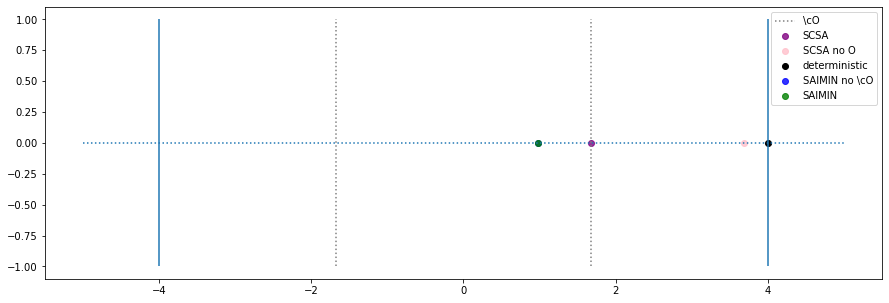

In [28]:
plt.figure(figsize=(15, 5))
plt.vlines([-beta / gamma, beta / gamma], ymin=-1, ymax=1)
plt.vlines([-SCSA_Beta[-2], SCSA_Beta[-1]], ymin=-1, ymax=1, label='\cO', color='grey', linestyle='dotted')
plt.hlines([0], xmin=-beta/gamma - 1, xmax=beta/gamma + 1, linestyle='dotted')
plt.scatter(x=[res_SCSA.x[0]], y=[0], color='purple', label='SCSA', alpha=0.8)
plt.scatter(x=[res_SCSA_no_O.x[0]], y=[0], color='pink', label='SCSA no O', alpha=0.8)
plt.scatter(x=[res_det.x[0]], y=[0], color='black', label='deterministic')
plt.scatter(x=[res_SAIMIN_no_O.x[0]], y=[0], color='blue', label='SAIMIN no \cO', alpha=0.8)
plt.scatter(x=[res_SAIMIN.x[0]], y=[0], color='green', label='SAIMIN', alpha=0.8)
plt.legend()

# Let us check what happens with samples and $\mathcal{P}$

In [17]:
[((A.dot(samples_SAIMIN[i]) - Beta_P) > 0).any()  for i in range(N)]

[True, True, True, True, True, True, True, True, True, True]

# Dope plot idea
Box plots for solution of scenario approx